## How to use

Choose 1 out of the 2 options:
- Hit "Run All" and start from the original datasets (check configs).
- Scroll down to Main Dataset section, there is option to load pre-prepped datasets, run the codes starting from there after configurations.

For easier readability: search "VS code jupyter notebook collapse all".

NOTE: In my results, the unified dataset contains 23419469 rows x 155 columns, assuming MAX 4 bytes (float) per data, is around 14.5 GB MAX. So make sure you have at least 15 GB if you intend to output the unified dataset.

## Configurations

In [1]:
dataset_input_dir = "dataset/full/"
dataset_output_dir = ""

user_dataset_input = dataset_input_dir + "users-details-2023.csv"                                                                                                                                                                                                   #p@stwi2x
user_dataset_output = dataset_output_dir + "user_dataset_prep.csv"
anime_dataset_input = dataset_input_dir + "anime-dataset-2023.csv"
anime_dataset_output = dataset_output_dir + "anime_dataset_prep.csv"
unified_dataset_input = dataset_input_dir + "users-score-2023.csv"
unified_dataset_output = dataset_output_dir + "unified_dataset_prep.csv"

from pyspark.sql import SparkSession
spark = SparkSession\
    .builder \
    .appName("Spark SQL app")\
    .getOrCreate()

25/03/21 17:55:14 WARN Utils: Your hostname, p4stwi2x resolves to a loopback address: 127.0.1.1; using 192.168.100.188 instead (on interface wlp2s0)
25/03/21 17:55:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/21 17:55:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Related functions

##### Simple functions

In [2]:
def print_shape(dataFrame):
    print(dataFrame.count(), len(dataFrame.columns))
def unique_categories(dataFrame, colName, show: bool = True):
    L = dataFrame.select(colName).rdd.flatMap(lambda x: x).collect()
    valueSet = {}
    for i in L:
        if i is not None:
            temp = i.split(", ")
            for j in temp:
                if colName + "_" + j not in valueSet.keys():
                    valueSet.update({colName + "_" + j: 1})
                else:
                    valueSet[colName + "_" + j] += 1
    if show:
        print(valueSet)
    return valueSet

##### One-hot encoding

In [3]:
# cre: https://stackoverflow.com/questions/62408093/one-hot-encoding-multiple-categorical-data-in-a-column
import gc
def oneHotEncoding(dataFrame, colName: str, show: bool = True, support: int = 0):
    size_before = dataFrame.count()

    test_df = dataFrame.select(colName)
    if show:
        print(f"Fill rate: {test_df.filter(col(colName).isNotNull()).count()}/{test_df.count()}")

    # collect list of unique genres
    valueSet = unique_categories(test_df, colName, show=False)
    # support
    for i in valueSet.copy():
        if valueSet[i] < support:
            valueSet.pop(i, None)

    # transfer unique values to panda DF to map the entries
    test_df_pd = test_df.dropDuplicates().toPandas()
    test_df_pd = test_df_pd.reindex(test_df_pd.columns.tolist() + list(valueSet), axis=1, fill_value=0)
    input_list = test_df_pd[colName].tolist()
    for i in range(len(input_list)):
        if input_list[i] is not None:
            temp = input_list[i].split(", ")
            for j in temp:
                if j is not None and colName + "_" + j in valueSet.keys():
                    test_df_pd.at[i, colName + "_" + j] = 1
    test_df = spark.createDataFrame(test_df_pd)
    if show:
        test_df.show()

    dataFrame = dataFrame.join(test_df, colName, "left").drop(colName) #hmmmm
    if show:
        dataFrame.show()
    # print(f"Size before: {size_before}")
    # print(f"Size after: {user_df.count()}")

    # clean up mem
    del [[test_df_pd]]
    gc.collect()

    return dataFrame


#### Normalization

For the main normalization for the common scale, choose one of the given functions.

Min max

In [39]:
from pyspark.sql.functions import min, max, col
def min_max(dataFrame, colName_in: str, colName_out: str):
    main = dataFrame.select(colName_in)
    filtered = main.filter(colName_in + " is not NULL")
    sc = filtered.select(min(colName_in), max(colName_in)).collect()
    mi, ma = float(sc[0][0]), float(sc[0][1])
    if mi == 0 and ma == 1:
        return dataFrame

    dataFrame = dataFrame.withColumn(colName_out, (col(colName_in)-mi)/(ma-mi))                                                                                                                                                                                         #thien7170

    return dataFrame

Standard score (z-score)

In [5]:
from pyspark.sql.functions import mean, stddev, col
def standard_score(dataFrame, colName_in: str, colName_out: str):
    main = dataFrame.select(colName_in)
    filtered = main.filter(colName_in + " is not NULL")
    sc = filtered.select(mean(colName_in), stddev(colName_in)).collect()
    m, std = sc[0][0], sc[0][1]

    dataFrame = dataFrame.withColumn(colName_out, (col(colName_in)-m)/std)

    return dataFrame

Main normalization

In [6]:
def main_normalization(dataFrame, colName_in: str, colName_out: str):
    return min_max(dataFrame, colName_in, colName_out)

##### Plot

In [7]:
from pyspark.sql.functions import min, max
import pandas as pd

def plot(dataFrame, colName: str):
    gre_histogram = dataFrame.select(colName).filter(col(colName).cast("float").isNotNull())\
        .rdd.flatMap(lambda x: x)\
        .map(float)\
        .histogram(20)

    pd.DataFrame(
        list(zip(*gre_histogram)), 
        columns=['bin', 'frequency']
    ).set_index('bin').plot(kind='bar')

## User dataset

### Dataset

In [8]:
user_df = spark.read\
    .option("header", True)\
    .option("escape", '"')\
    .option("multiline", True)\
    .option("sep", ",")\
    .csv(user_dataset_input)

# element: UNKNOWN
user_df = user_df.replace({'UNKNOWN': None, 'Unknown': None})
user_df.dropDuplicates()

start_X, start_Y = user_df.count(), len(user_df.columns)
print_shape(user_df)
user_df.show(20)

25/03/21 17:55:30 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


731290 16
+------+---------------+------+--------------------+--------------------+--------------------+------------+----------+--------+---------+-------+-------+-------------+-------------+---------+----------------+
|Mal ID|       Username|Gender|            Birthday|            Location|              Joined|Days Watched|Mean Score|Watching|Completed|On Hold|Dropped|Plan to Watch|Total Entries|Rewatched|Episodes Watched|
+------+---------------+------+--------------------+--------------------+--------------------+------------+----------+--------+---------+-------+-------+-------------+-------------+---------+----------------+
|     1|          Xinil|  Male|1985-03-04T00:00:...|          California|2004-11-05T00:00:...|       142.3|      7.37|     1.0|    233.0|    8.0|   93.0|         64.0|        399.0|     60.0|          8458.0|
|     3|        Aokaado|  Male|                NULL|        Oslo, Norway|2004-11-11T00:00:...|        68.6|      7.34|    23.0|    137.0|   99.0|   44.0| 

In [9]:
# check sparsity for each column
from pyspark.sql.functions import col
from collections import OrderedDict

rows = user_df.count()
sparsity_score = [user_df.filter(col(Col).isNotNull()).count() / rows for Col in user_df.columns]

sparsity_list = OrderedDict()
for i in range(len(user_df.columns)):
    sparsity_list[user_df.columns[i]] = sparsity_score[i]
#spark.createDataFrame([d_list]).show()
sparsity_list.items()

odict_items([('Mal ID', 1.0), ('Username', 0.999998632553433), ('Gender', 0.30683176304885884), ('Birthday', 0.22982400962682384), ('Location', 0.208885667792531), ('Joined', 1.0), ('Days Watched', 0.9999890604274638), ('Mean Score', 0.9999890604274638), ('Watching', 0.9999890604274638), ('Completed', 0.9999890604274638), ('On Hold', 0.9999890604274638), ('Dropped', 0.9999890604274638), ('Plan to Watch', 0.9999890604274638), ('Total Entries', 0.9999890604274638), ('Rewatched', 0.9999890604274638), ('Episodes Watched', 0.9999890604274638)])

### Data preprocessing

#### Username (finished)

This column is just user's username as strings, should be dropped to make the dataset lighter and we already have Mal ID as user index.

In [10]:
user_df = user_df.drop('Username')

#### Gender (finished)

As this categorical column has 2 values at most, we perform one-hot encoding.

In [11]:
print_shape(user_df)
user_df = oneHotEncoding(user_df, 'Gender', False)
print_shape(user_df)

731290 15


731290 17


#### Birthday (finished)

We shall convert the non-null values to unix timestamps.

In [12]:
from pyspark.sql.functions import split, unix_timestamp
split_col = split(user_df['Birthday'], 'T', 2)
user_df = user_df.withColumn('Birthday_d', split_col.getItem(0))\
    .withColumn('Birthday_unix', unix_timestamp('Birthday_d', format='yyyy-mm-dd'))\
    .drop('Birthday', 'Birthday_d')\
    .withColumnRenamed('Birthday_unix', 'Birthday')

In [13]:
user_df.select('Birthday').where('Birthday is not NULL').show(5)

+---------+
| Birthday|
+---------+
|569782920|
|664650600|
|473619780|
|570042060|
|631818120|
+---------+
only showing top 5 rows



It is worth noting that anime titles are vastly different for users of different ages, that is why we shall perform user age when giving rating.

However, for the time being, we shall perform a simple plotting and eliminating outliers.

In [14]:
user_df = min_max(user_df, 'Birthday', 'Birthday_m')\
    .drop('Birthday')\
    .withColumnRenamed('Birthday_m', 'Birthday')

731290 17


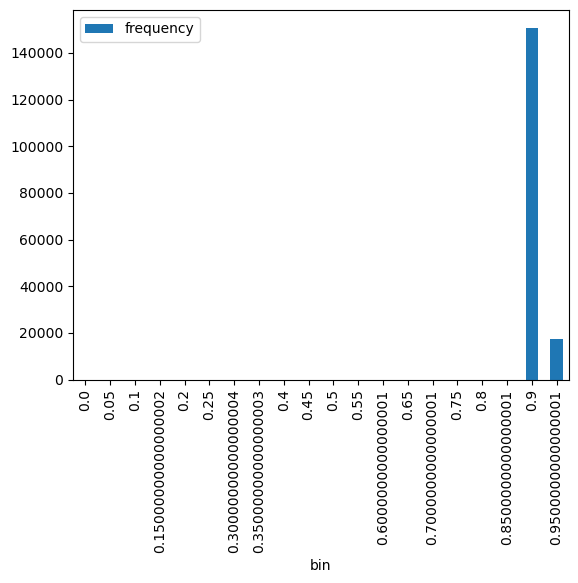

In [15]:
print_shape(user_df)
plot(user_df, 'Birthday')

731275 17


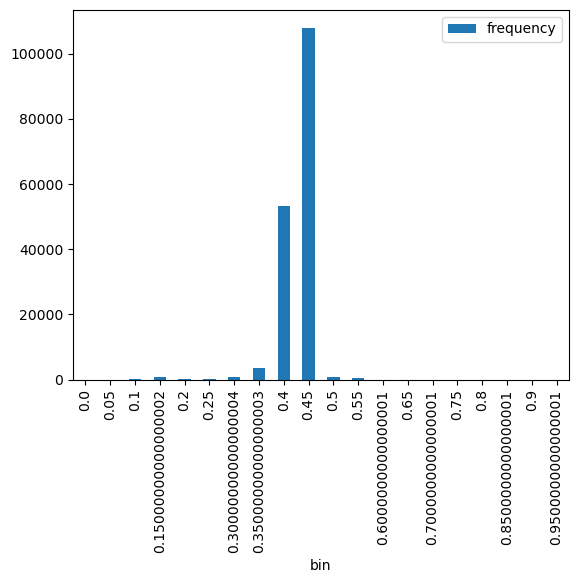

In [16]:
user_df = user_df.filter('Birthday is NULL OR Birthday >= 0.9')
user_df = min_max(user_df, 'Birthday', 'Birthday_m')\
    .drop('Birthday')\
    .withColumnRenamed('Birthday_m', 'Birthday')
print_shape(user_df)
plot(user_df, 'Birthday')

724456 17


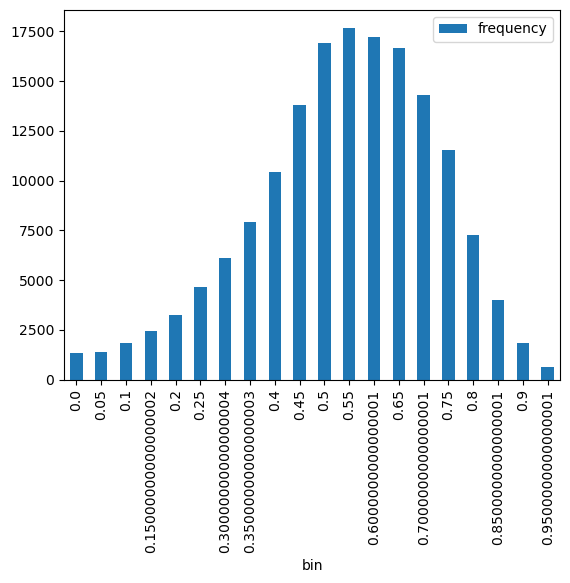

In [17]:
user_df = user_df.filter('Birthday is NULL OR (Birthday >= 0.4 AND Birthday < 0.5)')
user_df = min_max(user_df, 'Birthday', 'Birthday_m')\
    .drop('Birthday')\
    .withColumnRenamed('Birthday_m', 'Birthday')
print_shape(user_df)
plot(user_df, 'Birthday')

Examining the skewness of the observed data:

In [18]:
from pyspark.sql.functions import mean, median
user_df.select(mean('Birthday'), median('Birthday')).show()

+------------------+------------------+
|     avg(Birthday)|  median(Birthday)|
+------------------+------------------+
|0.5519932547907472|0.5524984815873584|
+------------------+------------------+



As the metrics are very close to each other, the skewness of the observed data should not be a concern for us.

In [19]:
print_shape(user_df)

724456 17


#### Location (finished)

In [20]:
user_df.select('Location').where('Location is not NULL').show()

+--------------------+
|            Location|
+--------------------+
|              Canada|
|Melbourne, Australia|
|              Canada|
|                 UAE|
|          California|
|        Oslo, Norway|
|      Bergen, Norway|
|Land of Rain and ...|
|31f288172a11dea9f...|
|         Calgary, AB|
|       Paris, France|
| Seattle, Washington|
|              Latvia|
|     good ol' Europe|
|      London,England|
| Lule&aring;, Sweden|
|     Ontario, Canada|
|Locked up in Shuu...|
|    Tampere, Finland|
|       Finland, Pori|
+--------------------+
only showing top 20 rows



As you can see, the location format is very inconsistent, going back and forth between cities and/or countries and imcomprehensible values. 

It is better for us to drop this column for now.

In [21]:
user_df = user_df.drop('Location')

#### Joined (finished)

This is the date when the user joins the MyAnimeList platform. If we intend to use this data to check user's anime-watching duration to give more weights to those who watch more and are able to rate titles more objectively, it shall be better to use the column "Days Watched" instead.

Hence, this column is dropped.

In [22]:
user_df = user_df.drop('Joined')

#### Days Watched (finished)

This column shows the number of days user has spent watching anime. The more experience one has with watching, one could judge and rate anime titles more accurately.

Hence, we use this column, with the name changed for easier SQL queries.

In [23]:
user_df = user_df.withColumnRenamed('Days Watched', 'Days_Watched')

The more time one spends watching anime, the more they can observe and rate anime titles more correctly. And the difference between experienced watchers (such as 1000 and 2000 hours) is not as much as between inexperienced (10 hours) and experienced (500 hours).

We shall perform log transformation then standardization and do not perform any outlier elimination.

In [24]:
from pyspark.sql.functions import log10, col
user_df = user_df.withColumn('Days_Watched_log', log10(col('Days_Watched')+1.0))\
.drop('Days_Watched')\
.withColumnRenamed('Days_Watched_log', 'Days_Watched')

user_df = main_normalization(user_df, 'Days_Watched', 'A1')\
    .drop('Days_Watched').withColumnRenamed('A1', 'Days_Watched')

user_df.select('Days_Watched').show(5)

+-------------------+
|       Days_Watched|
+-------------------+
| 0.2969307069606323|
| 0.3433040120799939|
|0.46390546083098444|
|0.42930947492004035|
| 0.3668642331580207|
+-------------------+
only showing top 5 rows



In [25]:
print_shape(user_df)

724456 15


#### Mean Score (finished)

This column is mean to see how user rates compared to how they usually rate, so it shall be left untouched until joining the datasets into one unified file.

#### Watching, On Hold, Dropped, Plan to Watch, Total Entries (finished)

These columns are to see how the user interacts with anime titles.

However, to us, these columns do not mean a lot about user's rating sincerity as we are recommending anime based on tastes.

In [26]:
user_df = user_df.drop('Watching', 'On Hold', 'Dropped', 'Plan to Watch', 'Total Entries')

#### Completed, Rewatched, Episodes Watched (finished)

These columns are important in determining user's experience in watching anime, similar to Days Watched. However, since Rewatched only counts number of titles a user has rewatched, without pointing out which titles exactly, and furthermore is similar to, and counted within, the Episodes Watched column.

Our decision is to drop Rewatched, and keep the other two, like Days Watched: log transformation.

In [27]:
user_df = user_df.drop('Rewatched')\
    .withColumnRenamed('Episodes Watched', 'Episodes_Watched')

a, b = 'Episodes_Watched', 'Completed'

user_df = user_df.withColumn(a + '_l', log10(col(a)+1.0))\
    .withColumn(b+ '_l', log10(col(b)+1.0))\
    .drop(a, b)\
    .withColumnRenamed(a+'_l', a)\
    .withColumnRenamed(b+'_l', b)

user_df = main_normalization(main_normalization(user_df, b, b+'_m'), a, a+'_m')\
    .drop(a,b)\
    .withColumnRenamed(a+'_m', a)\
    .withColumnRenamed(b+'_m', b)

user_df.select(a,b).show(5)

+-------------------+-------------------+
|   Episodes_Watched|          Completed|
+-------------------+-------------------+
|0.43296957900693545|0.42226835100537496|
| 0.4626086871667314|  0.499992032821234|
| 0.5454766530346725| 0.6803750397714515|
| 0.5216630439384277| 0.5748484952726145|
| 0.4795024105641635| 0.5192039674374592|
+-------------------+-------------------+
only showing top 5 rows



In [28]:
print_shape(user_df)

724456 9


#### Final results

In [29]:
print("Before: " + str(start_X) + " " + str(start_Y))
print("After: ", end = '')
print_shape(user_df)
user_df.show()

Before: 731290 16
After: 

724456 9
+------+----------+-----------+-------------+-----------------+-------------------+-------------------+-------------------+-------------------+
|Mal ID|Mean Score|Gender_Male|Gender_Female|Gender_Non-Binary|           Birthday|       Days_Watched|          Completed|   Episodes_Watched|
+------+----------+-----------+-------------+-----------------+-------------------+-------------------+-------------------+-------------------+
|     9|      7.71|       NULL|         NULL|             NULL|               NULL| 0.2969307069606323|0.42226835100537496|0.43296957900693545|
|    18|      6.27|       NULL|         NULL|             NULL|               NULL| 0.3433040120799939|  0.499992032821234| 0.4626086871667314|
|    23|      7.41|       NULL|         NULL|             NULL|0.40191615168022443| 0.4294300721561046| 0.6006780061626525| 0.5223881650875452|
|    53|      9.24|       NULL|         NULL|             NULL|               NULL| 0.2183952202750305| 0.4163579848100237|0.37

##### Saving preprocessed data

In [30]:
user_df.coalesce(1).write\
        .option("header", "true")\
        .option("sep", ",")\
        .mode("overwrite")\
        .csv(user_dataset_output)

## Anime dataset

### Dataset

In [31]:
anime_df = spark.read\
    .option("header", True)\
    .option("escape", '"')\
    .option("multiline", True)\
    .option("sep", ",")\
    .csv(anime_dataset_input)

# element: UNKNOWN
anime_df = anime_df.replace({'UNKNOWN': None, 'Unknown': None})
anime_df.dropDuplicates()

# change column names for better SQL
anime_df = anime_df.withColumnRenamed('Scored By', 'Scored_By')
start_X, start_Y = anime_df.count(), len(anime_df.columns)
print_shape(anime_df)
anime_df.show(20)

24905 24
+--------+--------------------+--------------------+------------------------------+-----+--------------------+--------------------+-----+--------+--------------------+-----------+----------------+--------------------+--------------------+----------------+-----------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+
|anime_id|                Name|        English name|                    Other name|Score|              Genres|            Synopsis| Type|Episodes|               Aired|  Premiered|          Status|           Producers|           Licensors|         Studios|     Source|     Duration|              Rating|  Rank|Popularity|Favorites|Scored_By|Members|           Image URL|
+--------+--------------------+--------------------+------------------------------+-----+--------------------+--------------------+-----+--------+--------------------+-----------+----------------+--------------------+--------------------+-------------

In [32]:
# check sparsity for each column
from pyspark.sql.functions import col
from collections import OrderedDict

rows = anime_df.count()
sparsity_score = [anime_df.filter(col(Col).isNotNull()).count() / rows for Col in anime_df.columns]

sparsity_list = OrderedDict()
for i in range(len(anime_df.columns)):
    sparsity_list[anime_df.columns[i]] = sparsity_score[i]
#spark.createDataFrame([d_list]).show()
sparsity_list.items()

odict_items([('anime_id', 1.0), ('Name', 1.0), ('English name', 0.4146958442079904), ('Other name', 0.9948604697851837), ('Score', 0.6300742822726361), ('Genres', 0.8020879341497691), ('Synopsis', 1.0), ('Type', 0.9970287090945593), ('Episodes', 0.9754667737402128), ('Aired', 1.0), ('Premiered', 0.2210801043967075), ('Status', 1.0), ('Producers', 0.463963059626581), ('Licensors', 0.1901224653683999), ('Studios', 0.5773539449909657), ('Source', 0.851877133105802), ('Duration', 0.9733788395904437), ('Rating', 0.9731379241116241), ('Rank', 0.8148163019474001), ('Popularity', 1.0), ('Favorites', 1.0), ('Scored_By', 0.6300742822726361), ('Members', 1.0), ('Image URL', 1.0)])

### Data preprocessing

#### Name, English name, Other name (finished)

Since the problem is about recommendation based on user's taste, it is expected that these features have nothing to do with our recommendation system.

In [33]:
anime_df = anime_df.drop("Name", "English name", "Other name")
anime_df.show()

+--------+-----+--------------------+--------------------+-----+--------+--------------------+-----------+----------------+--------------------+--------------------+----------------+-----------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+
|anime_id|Score|              Genres|            Synopsis| Type|Episodes|               Aired|  Premiered|          Status|           Producers|           Licensors|         Studios|     Source|     Duration|              Rating|  Rank|Popularity|Favorites|Scored_By|Members|           Image URL|
+--------+-----+--------------------+--------------------+-----+--------+--------------------+-----------+----------------+--------------------+--------------------+----------------+-----------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+
|       1| 8.75|Action, Award Win...|Crime is timeless...|   TV|    26.0|Apr 3, 1998 to Ap...|spring 1998| Fi

In [34]:
print_shape(anime_df)

24905 21


#### Score (finished)

As this is a numerical column, we perform data normalization.

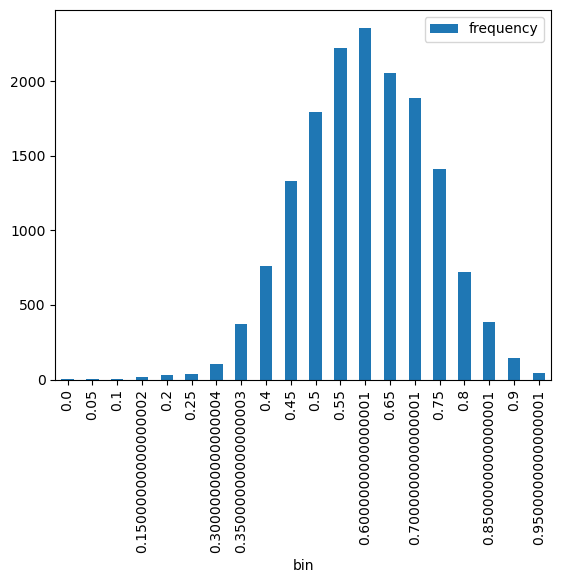

In [40]:
anime_df = main_normalization(anime_df, "Score", "Score_s").drop("Score")

anime_df = anime_df.withColumnRenamed(existing="Score_s",new="Score")

plot(anime_df, "Score")

In [41]:
from pyspark.sql.functions import median, mode
anime_df.select(median("Score"), mode("Score")).show()

+-----------------+------------------+
|    median(Score)|       mode(Score)|
+-----------------+------------------+
|0.626206896551724|0.6151724137931033|
+-----------------+------------------+



Even though the data is negatively skewed (mean = 0, median = 0.009, mode = 0.171), the skewed-ness is insignificant and can be allowed for analysis.

In [42]:
print_shape(anime_df)

24905 21


#### Genres (finished)

Since the column is categorical and the label order in Genres is not important, we use one-hot encoding.

In [43]:
anime_df = oneHotEncoding(anime_df, "Genres")

Fill rate: 19976/24905


+--------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+
|              Genres|Genres_Action|Genres_Award Winning|Genres_Sci-Fi|Genres_Adventure|Genres_Drama|Genres_Mystery|Genres_Supernatural|Genres_Fantasy|Genres_Sports|Genres_Comedy|Genres_Romance|Genres_Slice of Life|Genres_Suspense|Genres_Ecchi|Genres_Gourmet|Genres_Avant Garde|Genres_Horror|Genres_Girls Love|Genres_Boys Love|Genres_Hentai|Genres_Erotica|
+--------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+--------

25/03/21 18:02:16 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+--------------------+-----+--------+--------------------+-----------+----------------+--------------------+--------------------+--------------------+-----------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+
|anime_id|            Synopsis| Type|Episodes|               Aired|  Premiered|          Status|           Producers|           Licensors|             Studios|     Source|     Duration|              Rating|  Rank|Popularity|Favorites|Scored_By|Members|           Image URL|             Score|Genres_Action|Genres_Award Winning|Genres_Sci-Fi|Genres_Adventure|Genres_Drama|Ge

In [44]:
print_shape(anime_df)

24905 41


#### Synopsis (finished)

Synopsis is description of an anime title and has quite some impact to user's taste. However we temporarily leave this out for simplicity.

In [45]:
anime_df = anime_df.drop("Synopsis")

#### Type (finished)

Similar to Genres, we use one-hot encoding here.

In [46]:
anime_df.select("Type").groupBy("Type").count().show()

+-------+-----+
|   Type|count|
+-------+-----+
|     TV| 7597|
|   NULL|   74|
|Special| 2558|
|    OVA| 4076|
|  Music| 2686|
|  Movie| 4381|
|    ONA| 3533|
+-------+-----+



Since only 0.3% of samples have empty values, so we should have no problem dropping these rows.

In [47]:
anime_df = anime_df.filter("Type is not NULL")
anime_df.select("Type").groupBy("Type").count().show()

+-------+-----+
|   Type|count|
+-------+-----+
|     TV| 7597|
|Special| 2558|
|    OVA| 4076|
|  Music| 2686|
|  Movie| 4381|
|    ONA| 3533|
+-------+-----+



Then we perform one-hot encoding

In [48]:
anime_df = oneHotEncoding(anime_df, "Type")

Fill rate: 24831/24831
+-------+-------+--------+------------+----------+--------+----------+
|   Type|Type_TV|Type_OVA|Type_Special|Type_Movie|Type_ONA|Type_Music|
+-------+-------+--------+------------+----------+--------+----------+
|     TV|      1|       0|           0|         0|       0|         0|
|Special|      0|       0|           1|         0|       0|         0|
|    OVA|      0|       1|           0|         0|       0|         0|
|  Music|      0|       0|           0|         0|       0|         1|
|  Movie|      0|       0|           0|         1|       0|         0|
|    ONA|      0|       0|           0|         0|       1|         0|
+-------+-------+--------+------------+----------+--------+----------+



+--------+--------+--------------------+-----------+----------------+--------------------+--------------------+--------------------+-----------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+-------+--------+------------+----------+--------+----------+
|anime_id|Episodes|               Aired|  Premiered|          Status|           Producers|           Licensors|             Studios|     Source|     Duration|              Rating|  Rank|Popularity|Favorites|Scored_By|Members|           Image URL|             Score|Genres_Action|Genres_Award Winning|Genres_Sci-Fi|Genres_Adventure|Genres_D

In [49]:
print_shape(anime_df)

24831 45


#### Episodes (finished)

Anime length (no. of episodes and duration) might have to do with watching trends.

In [50]:
anime_df = main_normalization(anime_df, "Episodes", "A1").drop("Episodes")
anime_df = anime_df.withColumnRenamed("A1", "Episodes")

#### Aired (finished)

The format is in the form of "(start date) to (end date)", so we perform splitting into two columns.

In [51]:
# column: Aired 
from pyspark.sql.functions import split, to_date

split_col = split(anime_df["Aired"], " to ", 2)
anime_df = anime_df.withColumn("F1", split_col.getItem(0)).withColumn("F2", split_col.getItem(1))
anime_df = anime_df.withColumn("air_start", to_date(col("F1"), "MMM d, yyyy"))\
    .withColumn("air_end", to_date(col("F2"), "MMM d, yyyy"))\
    .drop("F1", "F2", "Aired")
anime_df.select("air_start", "air_end").show()

+----------+----------+
| air_start|   air_end|
+----------+----------+
|2004-10-06|2005-03-30|
|2002-10-03|2007-02-08|
|1999-10-20|      NULL|
|1998-04-01|1998-09-30|
|1995-10-04|1996-03-27|
|1998-04-03|1999-04-24|
|2004-04-17|2006-02-18|
|2002-07-03|2002-12-25|
|2003-04-17|2003-09-25|
|2004-10-08|2005-04-01|
|2004-10-06|2004-12-15|
|2005-04-29|2005-10-28|
|2004-09-30|2005-09-29|
|2005-04-15|2005-09-27|
|2004-10-12|2006-03-14|
|2004-10-05|2005-03-29|
|2002-09-11|2003-09-10|
|2004-04-07|2005-09-28|
|2005-04-06|2008-03-19|
|2001-10-10|2005-03-23|
+----------+----------+
only showing top 20 rows



In some cases, some titles do not have both timestamps.

In [52]:
print(anime_df.select("air_start", "air_end").where("air_start is not NULL").count())
print(anime_df.select("air_start", "air_end").where("air_end is not NULL").count())
print(anime_df.select("air_start", "air_end").where("air_start is not NULL AND air_end is not NULL").count())                                                               #p4stwi2x
print(anime_df.count())

20088


9337


9317


24831


Since the number of missing values is huge for both columns and users can manually filter the recommendation rankings, our choice is to drop the columns in processing.

In [53]:
anime_df = anime_df.drop("air_start", "air_end")
anime_df.show()

+--------+-----------+----------------+--------------------+--------------------+--------------------+-----------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+-------+--------+------------+----------+--------+----------+-------------------+
|anime_id|  Premiered|          Status|           Producers|           Licensors|             Studios|     Source|     Duration|              Rating|  Rank|Popularity|Favorites|Scored_By|Members|           Image URL|             Score|Genres_Action|Genres_Award Winning|Genres_Sci-Fi|Genres_Adventure|Genres_Drama|Genres_Mystery|Genres_Supernatural|

#### Premiered (finished)

Since some users might have the tendency to watch the latest titles, and so as some for the older titles for nostalgia, trendy eras, etc., we shall use this feature. The feature is in the form of season and year, which we shall transform into real numbers.

Column sparsity: 0.2210801043967075


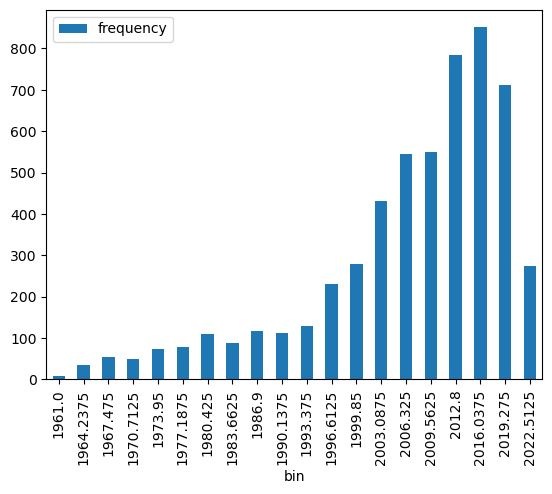

In [54]:
from pyspark.sql.functions import split, col

print(f"Column sparsity: {sparsity_list["Premiered"]}")

split_col = split(anime_df["Premiered"], " ", 2)
anime_df = anime_df.withColumn("F1", split_col.getItem(0)).withColumn("F2", split_col.getItem(1))
anime_df = anime_df.na.replace(['spring', 'summer', 'fall', 'winter'], ['0', '0.25', '0.5', '0.75'], 'F1')\
    .withColumn("Premiered_f", col('F1')+col('F2')).drop("Premiered", "F1", "F2")
plot(anime_df, "Premiered_f")

+--------------------+------------------+
|median(Premiered_fo)|mode(Premiered_fo)|
+--------------------+------------------+
|  0.7876447876447876|0.8648648648648649|
+--------------------+------------------+



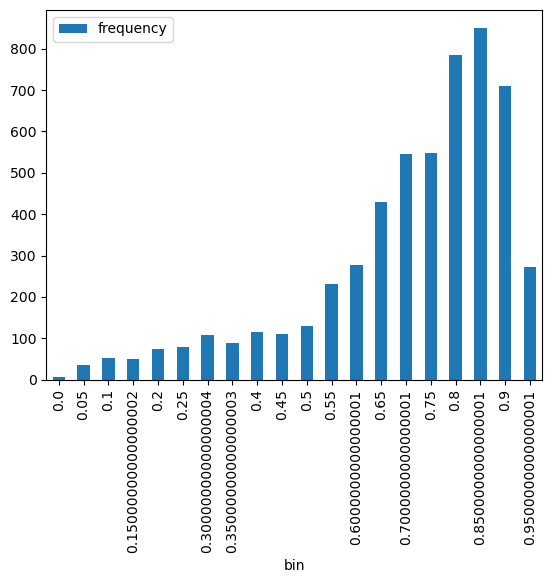

In [55]:
from pyspark.sql.functions import mean, median, mode
anime_df = main_normalization(anime_df, "Premiered_f", "Premiered_fo")

anime_df.select(median("Premiered_fo"), mode("Premiered_fo")).show()

anime_df = anime_df.drop("Premiered", "Premiered_f").withColumnRenamed(existing="Premiered_fo", new="Premiered")
plot(anime_df, "Premiered")

#### Status (finished)

List of unique values:

In [56]:
unique_categories(anime_df, "Status", show=False)

{'Status_Finished Airing': 24063,
 'Status_Currently Airing': 347,
 'Status_Not yet aired': 421}

Since the list is short, we shall perform one-hot encoding with no support without any issue.

In [57]:
anime_df = oneHotEncoding(anime_df, "Status", show=False)
anime_df.show()

+--------+--------------------+--------------------+--------------------+------------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+-------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+-------+--------+------------+----------+--------+----------+--------------------+------------------+----------------------+--------------------+-----------------------+
|anime_id|           Producers|           Licensors|             Studios|      Source|     Duration|              Rating|  Rank|Popularity|Favorites|Scored_By|Members|           Image URL|              Score|Genres_Action|Genres_Award Winning|Genres_Sci-Fi|Genres_Adventure|Genres_Drama|G

#### Producers (finished)

In [58]:
uVal = unique_categories(anime_df, "Producers", False)
print(uVal)

{'Producers_Fuji TV': 372, 'Producers_TAP': 4, 'Producers_Shueisha': 306, 'Producers_Twin Engine': 26, 'Producers_Tencent Penguin Pictures': 176, 'Producers_China Literature Limited': 37, 'Producers_Wanda Media': 2, 'Producers_Xiaoming Taiji': 1, 'Producers_iQIYI': 51, 'Producers_Xuanshi Tangmen': 6, 'Producers_Tianshi Wenhua': 2, 'Producers_Liu Cong Animation': 3, 'Producers_TMS Entertainment': 45, 'Producers_Tokyo MX': 174, 'Producers_BS11': 134, 'Producers_Kadokawa': 334, 'Producers_CTW': 7, 'Producers_Youku': 39, 'Producers_Ranzai Studio': 1, 'Producers_bilibili': 192, 'Producers_WOWOW': 65, 'Producers_Bushiroad': 123, 'Producers_BS Fuji': 82, 'Producers_Nippon Television Network': 154, 'Producers_Yomiuri TV Enterprise': 52, 'Producers_TO Books': 7, 'Producers_NetEase': 20, 'Producers_MediaNet Pictures': 7, 'Producers_Bandai Namco Music Live': 23, 'Producers_TV Tokyo': 573, 'Producers_Dentsu': 370, 'Producers_Pony Canyon': 387, 'Producers_Kodansha': 308, 'Producers_Ultra Super Pict

Too many columns so we have to add support. Firstly we have to plot the frequencies of the categories.

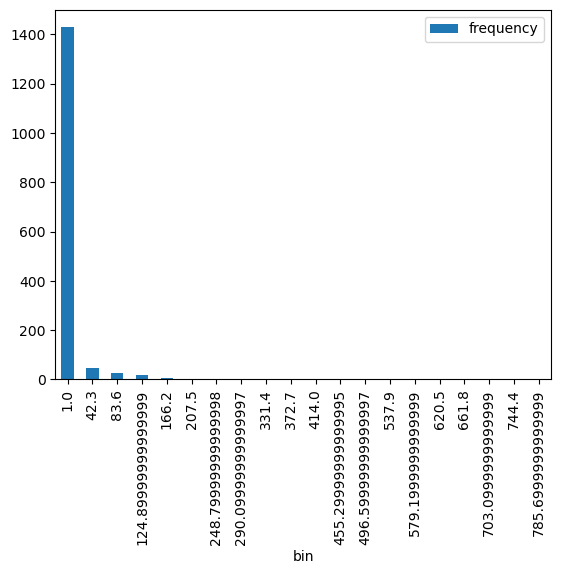

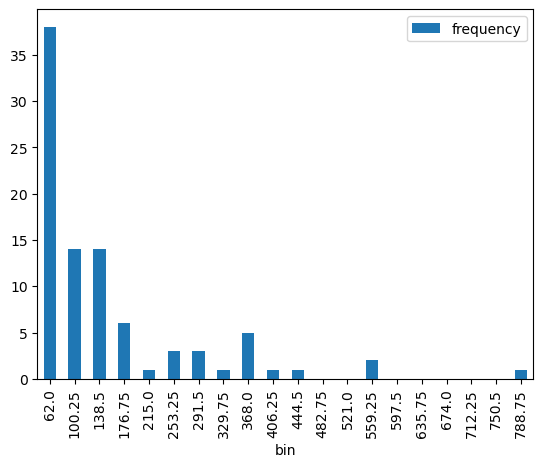

In [59]:
uVal_df = spark.createDataFrame(pd.DataFrame(list(uVal.values()), columns=['col1']))
plot(uVal_df, "col1")
plot(uVal_df.where("col1 > 60"), "col1")

In [60]:
print(uVal_df.count())
print(uVal_df.where("col1 >= 100").count())
print(uVal_df.where("col1 >= 150").count())
print(uVal_df.where("col1 >= 200").count())

1547
56
37
21


So we shall get support = 100 for 56 entries, in order to avoid having too much features causing overfitting.

In [61]:
print_shape(anime_df)
anime_df = oneHotEncoding(anime_df, "Producers", show=False, support=100)
print_shape(anime_df)
anime_df.show()

24831 46


24831 101


+--------+--------------------+--------------------+------------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+-------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+-------+--------+------------+----------+--------+----------+--------------------+------------------+----------------------+--------------------+-----------------------+-----------------+------------------+----------------------------------+------------------+--------------+------------------+------------------+-------------------+-----------------------------------+------------------+----------------+---------------------+------------------+--------------------+------------

#### Licensors (finished)

In [62]:
uVal = unique_categories(anime_df, "Licensors", False)
print(len(uVal))

87


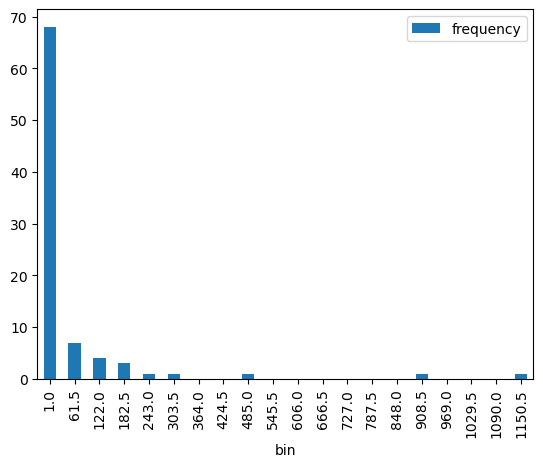

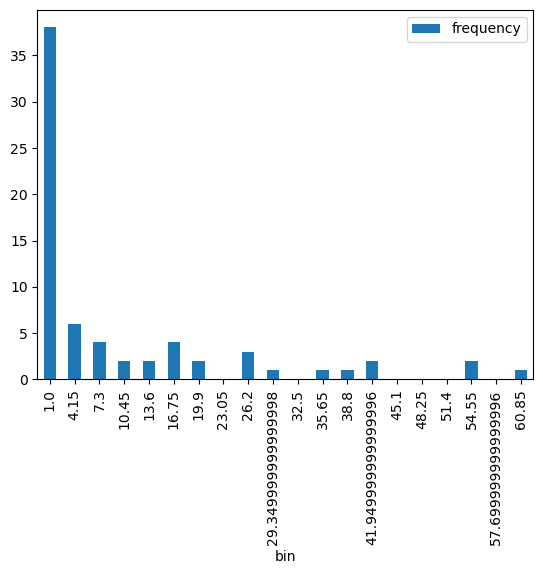

In [63]:
uVal_df = spark.createDataFrame(pd.DataFrame(list(uVal.values()), columns=['col1']))
plot(uVal_df, "col1")
plot(uVal_df.where("col1 < 65"), "col1")

In [64]:
print(uVal_df.count())
print(uVal_df.where("col1 >= 30").count())
print(uVal_df.where("col1 >= 50").count())
print(uVal_df.where("col1 >= 100").count())

87
26
21
13


In [65]:
print_shape(anime_df)
anime_df = oneHotEncoding(anime_df, "Licensors", show=False, support=100)
print_shape(anime_df)
anime_df.show()

24831 101


24831 113


+--------+--------------------+------------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+-------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+-------+--------+------------+----------+--------+----------+--------------------+------------------+----------------------+--------------------+-----------------------+-----------------+------------------+----------------------------------+------------------+--------------+------------------+------------------+-------------------+-----------------------------------+------------------+----------------+---------------------+------------------+--------------------+-----------------+---------------

#### Studios (finished)

In [66]:
uVal = unique_categories(anime_df, "Studios", False)
print(len(uVal))

1043


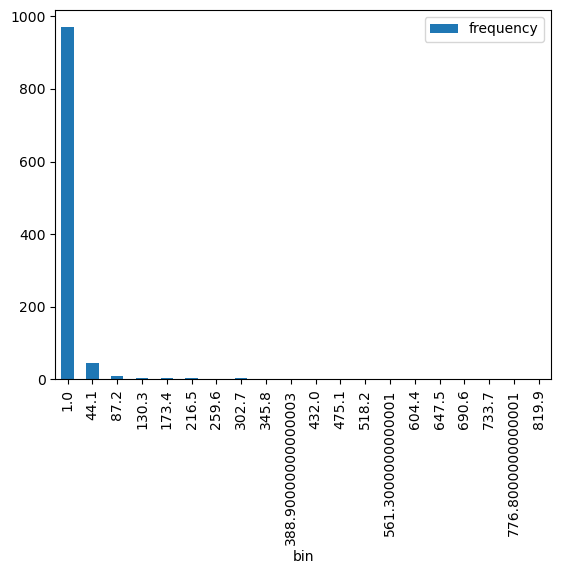

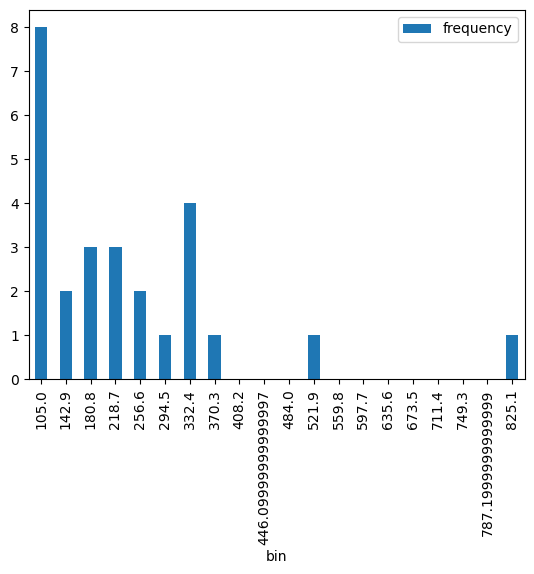

In [67]:
uVal_df = spark.createDataFrame(pd.DataFrame(list(uVal.values()), columns=['col1']))
plot(uVal_df, "col1")
plot(uVal_df.where("col1 > 100"), "col1")

In [68]:
print(uVal_df.count())
print(uVal_df.where("col1 >= 100").count())
print(uVal_df.where("col1 >= 150").count())

1043
26
18


In [69]:
print_shape(anime_df)
anime_df = oneHotEncoding(anime_df, "Studios", show=False, support=100)
print_shape(anime_df)
anime_df.show()

24831 113


24831 138


+--------+------------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+-------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+-------+--------+------------+----------+--------+----------+--------------------+------------------+----------------------+--------------------+-----------------------+-----------------+------------------+----------------------------------+------------------+--------------+------------------+------------------+-------------------+-----------------------------------+------------------+----------------+---------------------+------------------+--------------------+-----------------+---------------+--------------------

#### Source (finished)

In [70]:
uVal = unique_categories(anime_df, "Source", False)
print(len(uVal))

16


The number of categories is small, so we do not reduce.

In [71]:
print_shape(anime_df)
anime_df = oneHotEncoding(anime_df, "Source", show=False, support=100)
print_shape(anime_df)
anime_df.show()

24831 138


24831 150


+--------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+-------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+-------+--------+------------+----------+--------+----------+--------------------+------------------+----------------------+--------------------+-----------------------+-----------------+------------------+----------------------------------+------------------+--------------+------------------+------------------+-------------------+-----------------------------------+------------------+----------------+---------------------+------------------+--------------------+-----------------+---------------+---------------------+-----------

#### Duration (finished)

The format is "? hr ? min (per ep)", we shall convert to a single number representing the duration for each episode in minutes.

In [72]:
import pandas as pd

temp_df = anime_df.select("Duration")
#temp_df.show()

data = temp_df.toPandas()["Duration"].tolist()
new_d = []
for i in range(len(data)):
    if data[i] is not None:
        S = data[i].split(" per ep")[0]
        if "min" not in S:
            if "hr" in S:
                S += " 0 min"
            else:
                S = "0 min " + S
        if "hr" not in S:
            S = "0 hr " + S
        if "sec" not in S:
            S += " 0 sec"
        
        h, m, s = S.split(" hr ")[0], S.split(" hr ")[1].split(" min ")[0], S.split(" hr ")[1].split(" min ")[1].split(" sec")[0]
        new_d.append(int(h)*3600+int(m)*60+int(s))
    else:
        new_d.append(None)
print(len(new_d))
data = spark.createDataFrame(pd.DataFrame({
    'Duration': data,
    'Duration_f': new_d
})).dropDuplicates()

anime_df = anime_df.join(data, 'Duration', 'left').drop("Duration").withColumnRenamed(existing="Duration_f", new="Duration").dropDuplicates()                   #p4stwi2x
anime_df.show()

24831


+--------+--------------------+-------+----------+---------+---------+-------+--------------------+------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+-------+--------+------------+----------+--------+----------+-------------------+------------------+----------------------+--------------------+-----------------------+-----------------+------------------+----------------------------------+------------------+--------------+------------------+------------------+-------------------+-----------------------------------+------------------+----------------+---------------------+------------------+--------------------+-----------------+---------------+---------------------+------------------------+-

In [73]:
anime_df.count()

24831

#### Rating (finished)

This feature shall be used to filter the recommendation list by user's age and/or filter options, hence it is not to be in the processing.

In [74]:
anime_df = anime_df.drop("Rating")

#### Rank (finished)

From the author: "The rank of the anime based on popularity or other criteria". Since the metric is not clear and we are here to predict the ranking by ourselves, so it is better to have this feature removed.

In [75]:
anime_df = anime_df.drop("Rank")

#### Popularity (finished)

From the author: "The popularity rank of the anime". It is indeed that the more popular titles are likely to be watched by users, so they should appear higher on our predicted ranking list.

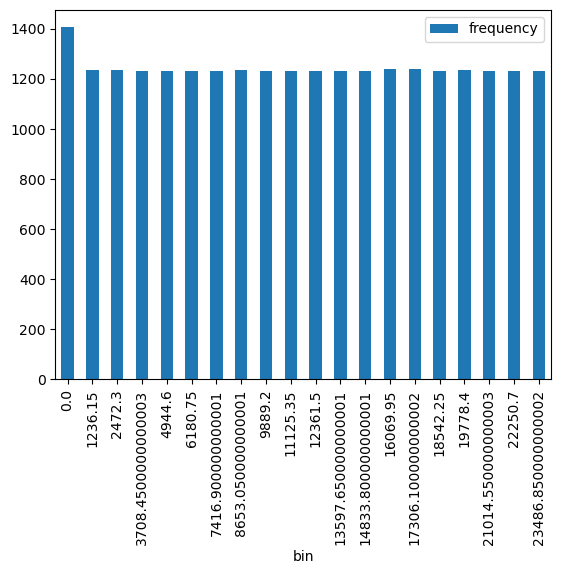

In [76]:
plot(anime_df, "Popularity")

However, it is indeed that this column is just the ranking for the titles, which do not have much value in determining the actual differences between the popularity of two different anime titles. So it is better for us to drop this and come up with a different way to get the popularity.

In [77]:
anime_df = anime_df.drop("Popularity")

#### Favorites, Scored By, Members (finished)

As we mentioned with the Popularity column, we shall find ways to represent an anime title's popularity. That is why we keep these 3 features.

In [78]:
anime_df = main_normalization(anime_df, "Favorites", "Favorites_s").drop("Favorites")                                                                                           #thien21127170
anime_df = main_normalization(anime_df, "Scored_By", "Scored_By_s").drop("Scored_By")
anime_df = main_normalization(anime_df, "Members", "Members_s").drop("Members")

This feature suggests the number of times an anime title is scored. As explained from the Popularity feature, this shall determine how popular a title is to be better on our ranking list.

In [79]:
anime_df = anime_df.withColumnRenamed('Favorites_s','Favorites')\
    .withColumnRenamed('Scored_By_s','Scored_By')\
    .withColumnRenamed('Members_s','Members')

#### Image URL (finished)

The feature has nothing to do with data processing, so the column is expected to be removed.

In [80]:
anime_df = anime_df.drop("Image URL")

#### Final results

In [81]:
print("Before: " + str(start_X) + " " + str(start_Y))
print("After: ", end = '')
print_shape(anime_df)
anime_df.show()

Before: 24905 24
After: 

24831 146


+--------+------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+-------+--------+------------+----------+--------+----------+-------------------+------------------+----------------------+--------------------+-----------------------+-----------------+------------------+----------------------------------+------------------+--------------+------------------+------------------+-------------------+-----------------------------------+------------------+----------------+---------------------+------------------+--------------------+-----------------+---------------+---------------------+------------------------+----------------+--------------+------------------+-------------+-------------------------

#### Saving preprocessed data

In [82]:
anime_df.coalesce(1).write\
        .option("header", "true")\
        .option("sep", ",")\
        .mode("overwrite")\
        .csv(anime_dataset_output)

## Main dataset

#### Optional: Read pre-prepped side datasets

Note: 
- Ctrl+A to choose all code lines.
- Ctrl+K then Ctrl+C to comment all lines selected.
- Ctrl+K then Ctrl+U to uncomment all lines selected.
- Change the csv paths ONLY.

In [ ]:
# anime_df = spark.read\
#     .option("header", True)\
#     .option("escape", '"')\
#     .option("multiline", True)\
#     .option("sep", ",")\
#     .csv("anime_dataset_prep.csv")
# user_df = spark.read\
#     .option("header", True)\
#     .option("escape", '"')\
#     .option("multiline", True)\
#     .option("sep", ",")\
#     .csv("user_dataset_prep.csv")

#### Read main dataset

In [94]:
main_df = spark.read\
    .option("header", True)\
    .option("escape", '"')\
    .option("multiline", True)\
    .option("sep", ",")\
    .csv(unified_dataset_input)

main_df.dropDuplicates()

start_X, start_Y = main_df.count(), len(main_df.columns)
print_shape(main_df)
main_df.show(20)

24325191 5
+-------+--------+--------+--------------------+------+
|user_id|Username|anime_id|         Anime Title|rating|
+-------+--------+--------+--------------------+------+
|      1|   Xinil|      21|           One Piece|     9|
|      1|   Xinil|      48|         .hack//Sign|     7|
|      1|   Xinil|     320|              A Kite|     5|
|      1|   Xinil|      49|    Aa! Megami-sama!|     8|
|      1|   Xinil|     304|Aa! Megami-sama! ...|     8|
|      1|   Xinil|     306|Abenobashi Mahou☆...|     8|
|      1|   Xinil|      53|       Ai Yori Aoshi|     7|
|      1|   Xinil|      47|               Akira|     5|
|      1|   Xinil|     591|      Amaenaide yo!!|     6|
|      1|   Xinil|      54|   Appleseed (Movie)|     7|
|      1|   Xinil|      55|         Arc the Lad|     5|
|      1|   Xinil|      56|             Avenger|     6|
|      1|   Xinil|      57|                Beck|     9|
|      1|   Xinil|     368|         Bible Black|     5|
|      1|   Xinil|      68|      Blac

#### Columns: Username, Anime Title

Since we already have the two ID columns, we shall remove these string columns to make the dataset far lighter.

In [95]:
main_df = main_df.drop('Username', 'Anime Title')

print_shape(main_df)

24325191 3


#### Datasets: Join [WARNING: PROCEED THIS WITH CAUTION]

We perform joining the datasets into one unified dataset.

In [96]:
main_df = main_df\
    .join(user_df, main_df['user_id'] == user_df['Mal ID'])\
    .join(anime_df, main_df['anime_id'] == anime_df['anime_id'])

main_df = main_df.drop(user_df['Mal ID'], anime_df['anime_id'])

print_shape(main_df)

23419469 158


#### User: Mean Score (finished)

As mentioned in the user dataset, Mean Score column shall be used with rating score in main dataset to get what users actually gets towards the anime titles.

In [97]:
from pyspark.sql.functions import col
main_df = main_df.withColumn('actual_rating', col('rating') - col('Mean Score'))\
    .drop('rating', 'Mean Score')\
    .withColumnRenamed('actual_rating', 'rating')

#### Saving data (very, very long > 8 mins)

Note: 
- Ctrl+A to choose all code lines.
- Ctrl+K then Ctrl+C to comment all lines selected.
- Ctrl+K then Ctrl+U to uncomment all lines selected.

In [ ]:
# main_df.coalesce(1).write\
#         .option("header", "true")\
#         .option("sep", ",")\
#         .mode("overwrite")\
#         .csv(unified_dataset_output)

## Ending process

In [103]:
print_shape(main_df)
main_df.show()

23419469 155


+-------+--------+-----------+-------------+-----------------+-------------------+-------------------+------------------+-------------------+------------------+-------------+--------------------+-------------+----------------+------------+--------------+-------------------+--------------+-------------+-------------+--------------+--------------------+---------------+------------+--------------+------------------+-------------+-----------------+----------------+-------------+--------------+-------+--------+------------+----------+--------+----------+-------------------+---------+----------------------+--------------------+-----------------------+-----------------+------------------+----------------------------------+------------------+--------------+------------------+------------------+-------------------+-----------------------------------+------------------+----------------+---------------------+------------------+--------------------+-----------------+---------------+---------------

In [104]:
spark.stop()